In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [7]:
!tree -d /kaggle/input/fresh-and-stale-classification/dataset 

/kaggle/input/fresh-and-stale-classification/dataset
|-- Test
|   |-- freshapples
|   |-- freshbanana
|   |-- freshcucumber
|   |-- freshokra
|   |-- freshoranges
|   |-- freshpatato
|   |-- freshtamto
|   |-- rottenapples
|   |-- rottenbanana
|   |-- rottencucumber
|   |-- rottenokra
|   |-- rottenoranges
|   |-- rottenpatato
|   `-- rottentamto
`-- Train
    |-- freshapples
    |-- freshbanana
    |-- freshbittergroud
    |-- freshcapsicum
    |-- freshcucumber
    |-- freshokra
    |-- freshoranges
    |-- freshpotato
    |-- freshtomato
    |-- rottenapples
    |-- rottenbanana
    |-- rottenbittergroud
    |-- rottencapsicum
    |-- rottencucumber
    |-- rottenokra
    |-- rottenoranges
    |-- rottenpotato
    `-- rottentomato

34 directories


In [9]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to your dataset
data_dir = '/kaggle/input/fresh-and-stale-classification/dataset'

# Define transformations for the training set
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resizing the image to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Function to map multiple directories to two categories (fresh or rotten)
class CustomDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.root = root

    def find_classes(self, directory):
        fresh_classes = [cls for cls in os.listdir(directory) if cls.startswith('fresh')]
        rotten_classes = [cls for cls in os.listdir(directory) if cls.startswith('rotten')]

        class_to_idx = {cls: 0 for cls in fresh_classes}  # Map fresh to label 0
        class_to_idx.update({cls: 1 for cls in rotten_classes})  # Map rotten to label 1
        
        return ['fresh', 'rotten'], class_to_idx

# Creating dataset and DataLoader
train_dataset = CustomDataset(os.path.join(data_dir, 'Train'), transform=data_transforms['Train'])
test_dataset = CustomDataset(os.path.join(data_dir, 'Test'), transform=data_transforms['Test'])


Batch of images has shape: torch.Size([32, 3, 224, 224])
Batch of labels has shape: torch.Size([32])


In [22]:


train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=192, shuffle=False)

# Sample check
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f'Batch of images has shape: {images.shape}')
print(f'Batch of labels has shape: {labels.shape}')


Batch of images has shape: torch.Size([192, 3, 224, 224])
Batch of labels has shape: torch.Size([192])


In [20]:
!mkdir /kaggle/working/models

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import TQDM for progress bar
import copy  # To keep a copy of the best model

# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to fit our binary classification task (fresh vs rotten)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Move the model to the device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with TQDM and model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path="/kaggle/working/models"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Progress bar for training batches
        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

        # Iterate over data
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        # Progress bar for validation batches
        val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)

        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}\n')

        # Save the last model
        torch.save(model.state_dict(), f"{save_path}/last_model.pth")

        # Check if it's the best model and save it
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, f"{save_path}/best_model.pth")
            print(f"Best model saved with accuracy: {best_acc:.4f}")

    return model

# Assuming `train_loader` and `test_loader` are your DataLoaders
num_epochs = 5
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)


Epoch 1/5


Loss: 0.0952 | Accuracy: 0.9615


Validation Loss: 0.0438 | Validation Accuracy: 0.9834

Best model saved with accuracy: 0.9834
Epoch 2/5


Loss: 0.0321 | Accuracy: 0.9889


Validation Loss: 0.3969 | Validation Accuracy: 0.8752

Epoch 3/5


Loss: 0.1005 | Accuracy: 0.9643


Validation Loss: 0.0347 | Validation Accuracy: 0.9872

Best model saved with accuracy: 0.9872
Epoch 4/5


Loss: 0.0261 | Accuracy: 0.9907


Validation Loss: 1.4265 | Validation Accuracy: 0.8494

Epoch 5/5


Loss: 0.1144 | Accuracy: 0.9564


Validation Loss: 0.0432 | Validation Accuracy: 0.9849



In [27]:
import torch
import torch.nn as nn
from torchvision import models

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Reinitialize the MobileNetV2 model
# Set pretrained=False since we're loading our own weights
model1 = models.mobilenet_v2(pretrained=False)

# Step 2: Modify the classifier for binary classification
# The classifier is a Sequential model; we replace the last Linear layer
num_classes = 2  # Number of classes in your dataset (e.g., 'fresh' and 'rotten')
model1.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Step 3: Load the saved weights
# Provide the path to your saved model weights
checkpoint_path = "/kaggle/working/models/best_model.pth"
model1.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Step 4: Move the model to the device
model1 = model1.to(device)

# Step 5: Set the model to evaluation mode
model1.eval()

print("Model reinitialized and weights loaded successfully.")


Model reinitialized and weights loaded successfully.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/3917114016.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

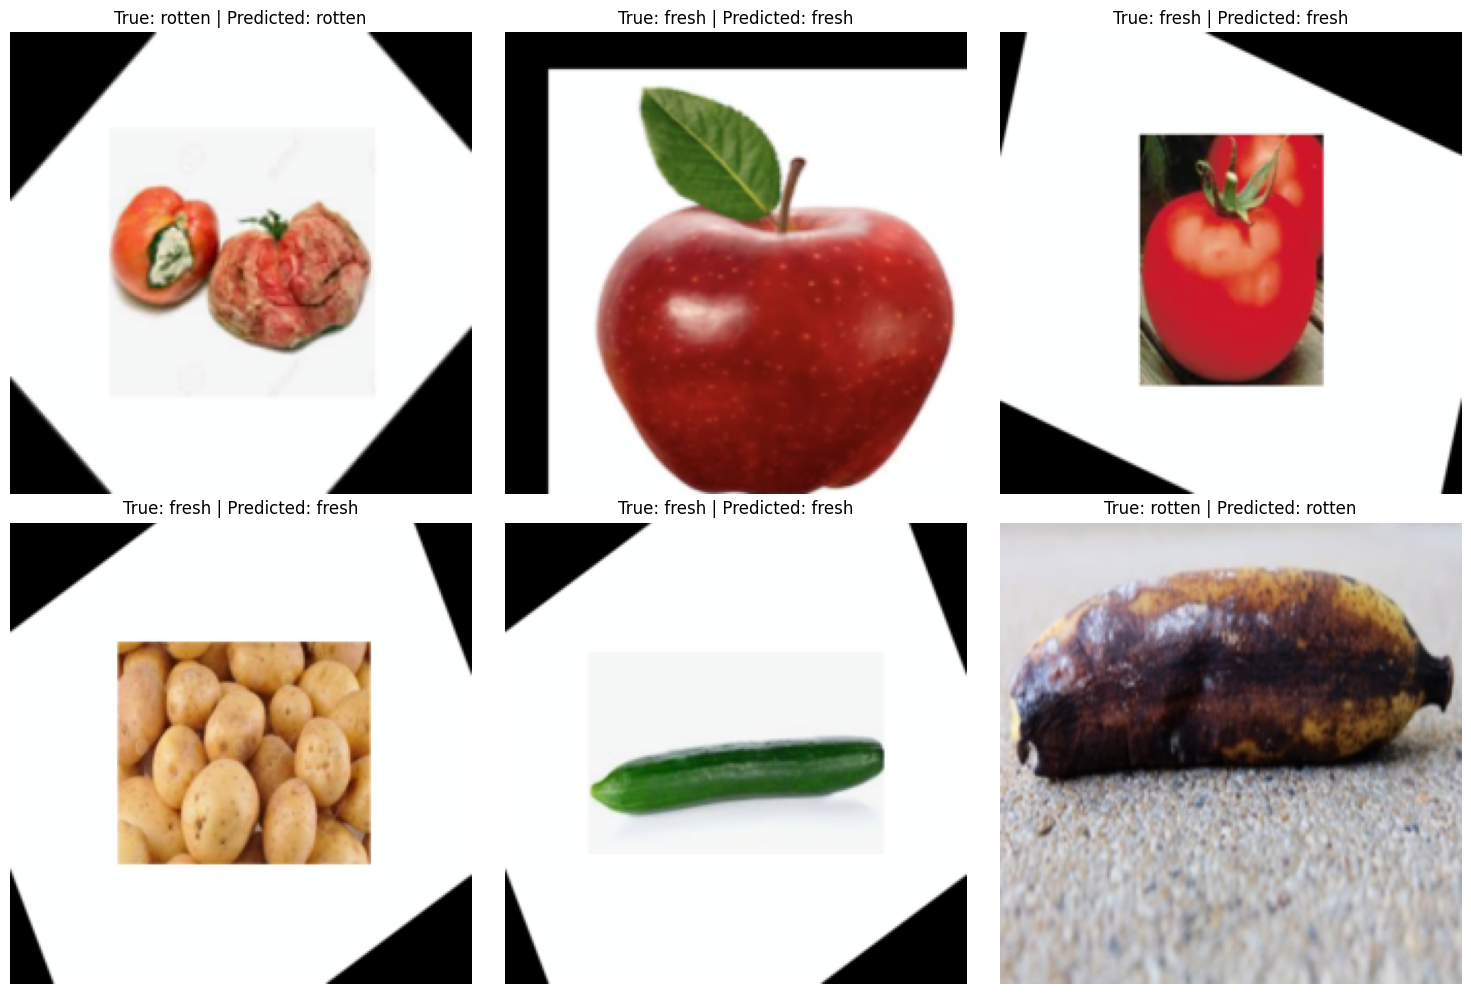

In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy

# Define class names
class_names = ['fresh', 'rotten']  # Replace with your actual class names

# Ensure model is in evaluation mode
model1.eval()

# Function to unnormalize and display an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])  # Mean used in preprocessing
    std = np.array([0.229, 0.224, 0.225])   # Std used in preprocessing
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Select 6 random samples from the test dataset
num_samples = 6
indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in indices]

# Prepare a figure
plt.figure(figsize=(15, 10))

for idx, (inputs, labels) in enumerate(samples):
    inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
    # No need to move labels to device
    # labels = labels.to(device)  # Remove this line

    # Forward pass to get outputs
    outputs = model1(inputs)
    _, preds = torch.max(outputs, 1)

    # Move data to CPU and detach
    inputs = inputs.cpu().squeeze(0)  # Remove batch dimension
    preds = preds.cpu()

    # Convert preds to integer
    preds = preds.item()

    # Display the image
    plt.subplot(2, 3, idx + 1)
    imshow(inputs, title=f'True: {class_names[labels]} | Predicted: {class_names[preds]}')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/2207112585.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Classification Report:
              precision    recall  f1-score   support

       fresh       0.98      1.00      0.99      3245
      rotten       1.00      0.98      0.99      3493

    accuracy                           0.99      6738
   macro avg       0.99      0.99      0.99      6738
weighted avg       0.99      0.99      0.99      6738



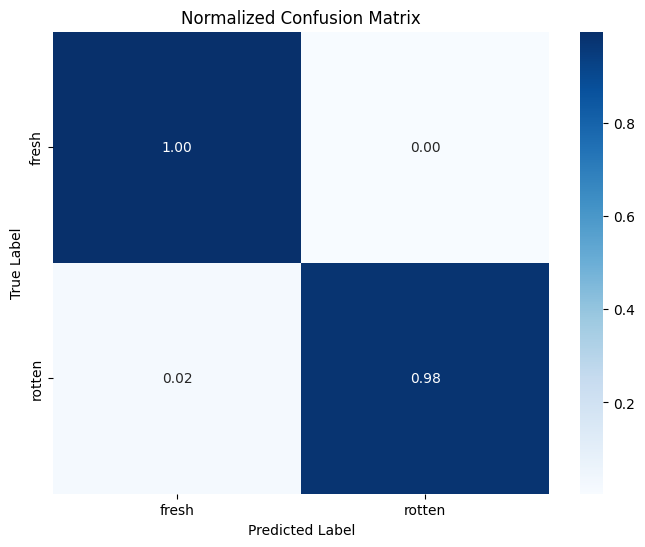

In [33]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names
class_names = ['fresh', 'rotten']  # Replace with your actual class names
num_classes = len(class_names)

# Reinitialize and load your model
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load("/kaggle/working/models/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Append to lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


---